In [1]:
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time

In [2]:
import tensorflow as tf

2024-11-12 12:36:29.681547: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-12 12:36:29.681592: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-12 12:36:29.682557: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 12:36:29.689835: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# !pip install tensorflow

In [3]:
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

import torch
print("CUDA available:", torch.cuda.is_available())

print("GPU in use:", torch.cuda.current_device())
torch.cuda.empty_cache()

CUDA available: False


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [4]:
def make_confusion_matrices(y_train, preds_train, y_test, preds_test):
    
    def make_conf_matrix(y, preds):
        conf_matrix = confusion_matrix(y, preds, labels=y.unique(), normalize='pred')
        classes = y.value_counts().sort_values(ascending=False).index
        conf_matrix_df = pd.DataFrame(conf_matrix, index=classes, columns=classes)
        return conf_matrix_df

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 13))
    conf_matrix_train = make_conf_matrix(y_train, preds_train)
    sns.heatmap(conf_matrix_train, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True, 
                linewidths=0.5, linecolor='gray', square=True, annot_kws={"size": 8}, ax=ax1)
    ax1.set_title('Train Precision')
    ax1.set_xlabel('Predicted Labels')
    ax1.set_ylabel('True Labels')
    
    conf_matrix_test = make_conf_matrix(y_test, preds_test)
    sns.heatmap(conf_matrix_test, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True, 
                linewidths=0.5, linecolor='gray', square=True, annot_kws={"size": 8}, ax=ax2)
    ax2.set_title('Test Precision')
    ax2.set_xlabel('Predicted Labels')
    ax2.set_ylabel('True Labels')

    plt.tight_layout(rect=[0.0, 0.0, 1, 1])
    plt.subplots_adjust(wspace=0.5, hspace=0.55)
    plt.show()

In [5]:
# inflows = pd.read_parquet('data/ucsd-inflows.pqt')
# outflows = pd.read_parquet('data/ucsd-outflows.pqt')

outflows = pd.read_parquet('data/ucsd-outflows.pqt')

In [6]:
relevant_of = outflows[outflows.category != outflows.memo].reset_index(drop=True)
relevant_of.posted_date = pd.to_datetime(relevant_of.posted_date)
relevant_of.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,18.4200,2022-09-26,FOOD_AND_BEVERAGES
1,0,acc_0,Buffalo Wild Wings,26.4700,2022-09-12,FOOD_AND_BEVERAGES
2,0,acc_0,Oculus CA 04/16,11.7300,2022-04-18,GENERAL_MERCHANDISE
3,0,acc_0,LOS GIRASOLES STOW OH 03/08,30.0400,2022-03-09,FOOD_AND_BEVERAGES
4,0,acc_0,BUZZIS LAUNDRY 1 OH 03/28,4.1600,2022-03-29,GENERAL_MERCHANDISE


# Memo Cleaning

In [7]:
def clean_memo(memo):
    sw = ['payment', 'transaction', 'deposit', 'withdrawal', 'transfer', 'credit', 'debit', 'refund', 'fee', 'charge', 'purchase', 'atm', 'checkcard']

    memo = memo.lower()

    memo = re.sub(r'[0-9]{3,}', '', memo) # remove instances of numbers more than 3 repeated
    
    memo = re.sub(r'x{3,}', '', memo) # remove the X's (ex. #XXXX)
    memo = re.sub(r'^#[a-z0-9]+', '', memo) # remove the #smth @ start of memo
    memo = re.sub(r'(www\.|\.com)', '', memo) # removing any links or urls

    memo = re.sub(r'[0-9x]{2}((-|/)[0-9x]{2,4}){1,2}', '', memo) # remove dates

    memo = re.sub(r'[^\w\s-]', ' ', memo)  # replace special characters with single space
    memo = re.sub(r'([a-z]+)\s{0,1}-\s{0,1}([a-z]+)', r'\1\2', memo) # replace '-' w/ ''
    memo = re.sub(r'\s+', ' ', memo)  # remove multiple spaces

    # location
    state_abbreviations = [
        "al", "ak", "az", "ar", "ca", "co", "ct", "de", "fl", "ga", 
        "hi", "id", "il", "in", "ia", "ks", "ky", "la", "me", "md", 
        "ma", "mi", "mn", "ms", "mo", "mt", "ne", "nv", "nh", "nj", 
        "nm", "ny", "nc", "nd", "oh", "ok", "or", "pa", "ri", "sc", 
        "sd", "tn", "tx", "ut", "vt", "va", "wa", "wv", "wi", "wy"
    ]
    state_pattern = r' (' + '|'.join(state_abbreviations) + r')\b'
    
    memo = re.sub(r'(street|st|road|rd|blvd|avenue|ave|highway|hwy)\b', '', memo)
    memo = memo.strip()
    memo = re.sub(state_pattern, '', memo)
    memo = memo.strip()

    merchant_map = {'wal walmart': 'walmart', 'walmart walmart': 'walmart', 'wal mart': 'walmart'}

    if memo in merchant_map: return merchant_map[memo]
    return memo

In [8]:
relevant_of['clean_memo'] = relevant_of.apply(lambda row: clean_memo(row.memo) if row.memo != row.category else row.memo, axis=1)

relevant_of.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category,clean_memo
0,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,18.4200,2022-09-26,FOOD_AND_BEVERAGES,t casa del rioexp fairlawn
1,0,acc_0,Buffalo Wild Wings,26.4700,2022-09-12,FOOD_AND_BEVERAGES,buffalo wild wings
2,0,acc_0,Oculus CA 04/16,11.7300,2022-04-18,GENERAL_MERCHANDISE,oculus
3,0,acc_0,LOS GIRASOLES STOW OH 03/08,30.0400,2022-03-09,FOOD_AND_BEVERAGES,los girasoles stow
4,0,acc_0,BUZZIS LAUNDRY 1 OH 03/28,4.1600,2022-03-29,GENERAL_MERCHANDISE,buzzis laundry 1


In [9]:
# vectorizer = TfidfVectorizer(max_features=1000, max_df=0.85)
# tfidf = vectorizer.fit_transform(clean_data.clean_memo)
# tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf)
# tfidf_df.columns = vectorizer.get_feature_names_out()

In [10]:
def ftr_generation(data, num_bins=10, max_features=1000, max_df=0.85):
    to_remove = ['prism_account_id', 'memo', 'amount', 'posted_date', 'clean_memo',]

    # Binary data
    data['is_weekend'] = (data.posted_date.dt.weekday >= 5).astype(int)
    data['is_even_amount'] = data.amount.apply(lambda x: 1 if x % 1 == 0 and x % 5 == 0 else 0)

    # tifidf data
    vectorizer = TfidfVectorizer(max_features=max_features, max_df=max_df)
    tfidf = vectorizer.fit_transform(data.clean_memo)
    tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf)
    tfidf_df.columns = 'tfidf_' + vectorizer.get_feature_names_out()

    # date data
    date_data = pd.DataFrame()
    date_data['month'] = 'month_' + data.posted_date.dt.month.astype(str)
    date_data['weekday'] = 'weekday_' + data.posted_date.dt.weekday.astype(str)

    date_enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    date_oh = date_enc.fit_transform(date_data)

    cols = np.concatenate([typ[1:] for typ in date_enc.categories_])
    date_ftrs = pd.DataFrame.sparse.from_spmatrix(date_oh, columns=cols)

    # amount features
    amount_data = pd.DataFrame()
    amount_data['decile_amounts'] = pd.qcut(data.amount, q=10, labels=[f'bin_{num}' for num in range(1, num_bins + 1)])
    
    amount_enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    amount_oh = amount_enc.fit_transform(amount_data)

    cols = np.concatenate([typ[1:] for typ in amount_enc.categories_])
    amount_ftrs = pd.DataFrame.sparse.from_spmatrix(amount_oh, columns=cols)
    

    return pd.concat([data, amount_ftrs, date_ftrs, tfidf_df], axis=1).drop(columns=to_remove)

In [11]:
idmap = {relevant_of.category.unique()[i] : i for i in range(len(relevant_of.category.unique()))}
idmap

{'FOOD_AND_BEVERAGES': 0,
 'GENERAL_MERCHANDISE': 1,
 'GROCERIES': 2,
 'PETS': 3,
 'TRAVEL': 4,
 'MORTGAGE': 5,
 'OVERDRAFT': 6,
 'EDUCATION': 7,
 'RENT': 8}

In [12]:
model_ftrs = ftr_generation(relevant_of)
# model_ftrs['category_id'] = model_ftrs.category.apply(lambda cat: idmap[cat]) ### FIX LATER ##
# model_ftrs.drop(columns=['category'], inplace=True)
model_ftrs.head() 

# 9 seconds

,prism_consumer_id,category,is_weekend,is_even_amount,bin_10,bin_2,bin_3,bin_4,bin_5,bin_6,...,tfidf_world,tfidf_worth,tfidf_xfer,tfidf_xsolla,tfidf_york,tfidf_your,tfidf_youtube,tfidf_zaxby,tfidf_zelle,tfidf_zip
0,0,FOOD_AND_BEVERAGES,0,0,0,0,0,0,1.0000,0,...,0,0,0,0,0,0,0,0,0,0
1,0,FOOD_AND_BEVERAGES,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,GENERAL_MERCHANDISE,0,0,0,0,0,1.0000,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,FOOD_AND_BEVERAGES,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,GENERAL_MERCHANDISE,0,0,0,1.0000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# model_ftrs.drop(columns=['category'], inplace=True)

model_ftrs.shape # 28 + 1 for category (daniel 57)

(1306452, 1030)

In [20]:
# is_weekend vs day_of_month

# Sanity Check

- \# of rows should be **1306452**
- 1028 ftrs = 1000 tfidf + 9 bins + 11 months + 6 days + is_even + is_weekend

In [21]:
model_ftrs.columns[:28].values

array(['prism_consumer_id', 'category', 'is_weekend', 'is_even_amount',
       'bin_10', 'bin_2', 'bin_3', 'bin_4', 'bin_5', 'bin_6', 'bin_7',
       'bin_8', 'bin_9', 'month_10', 'month_11', 'month_12', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4'],
      dtype=object)

# Train / Test Sets (by Consumer Sampling)

In [22]:
# test_df = pd.concat([relevant_of[['prism_consumer_id']], model_ftrs], axis=1)
# train_df = pd.DataFrame(columns=test_df.columns)
# to_add = []

# ids = test_df.prism_consumer_id.unique()

# for _ in range(training_size):
#     curr_id = np.random.choice(ids)

#     temp = test_df[test_df.prism_consumer_id == curr_id]
#     if temp.shape[0] > 0:
#         row = temp.sample(n=1,)
#         test_df.drop(row.index, inplace=True)

#     else:
#         row = train_df[train_df.prism_consumer_id == curr_id].sample(n=1, replace=True)

#     to_add.append(row)
        

# Model Training

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [15]:
# model_ftrs.to_csv('model_ftrs_df.csv')

In [16]:
model_ftrs_sample = model_ftrs.sample(frac=0.3)
ids = model_ftrs_sample.prism_consumer_id.unique()

test_ratio = 0.25
test_size = int(len(ids) * 0.25)

test_ids = np.random.choice(ids, size=test_size, replace=False)

train = model_ftrs_sample[~model_ftrs_sample.prism_consumer_id.isin(test_ids)]
test = model_ftrs_sample[model_ftrs_sample.prism_consumer_id.isin(test_ids)]


In [45]:
ids = model_ftrs.prism_consumer_id.unique()

test_ratio = 0.25
test_size = int(len(ids) * 0.25)

test_ids = np.random.choice(ids, size=test_size, replace=False)

In [46]:
train = model_ftrs[~model_ftrs.prism_consumer_id.isin(test_ids)]
test = model_ftrs[model_ftrs.prism_consumer_id.isin(test_ids)]

In [47]:
X_train = train.drop(columns=['prism_consumer_id', 'category'])
y_train = train.category

X_test = test.drop(columns=['prism_consumer_id', 'category'])
y_test = test.category

del train
del test

In [48]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((977220, 1028), (977220,), (329232, 1028), (329232,))

In [28]:
X_train_sparse = X_train.astype({col: pd.SparseDtype(X_train[col].dtype, fill_value=0) for col in X_train.columns})

In [29]:
X_train_sparse.shape

(490831, 1028)

# Logistic Regression

In [32]:
lr = LogisticRegression(max_iter=100, random_state=42, n_jobs=4, penalty='elasticnet', solver='saga', l1_ratio=0.5)
# lr.to('cuda')
lr

LogisticRegression(l1_ratio=0.5, n_jobs=4, penalty='elasticnet',
                   random_state=42, solver='saga')

In [33]:
lr.fit(X_train_sparse, y_train) # Increase max_iter if needed -- never converges


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(l1_ratio=0.5, n_jobs=4, penalty='elasticnet',
                   random_state=42, solver='saga')

In [38]:
y_pred = lr.predict(X_test)
y_pred_train = lr.predict(X_train)

/home/akar/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/akar/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [39]:
test_acc = (y_test == y_pred).mean()
test_acc

0.8955180250266391

In [40]:
train_acc = (y_train == y_pred_train).mean()
train_acc

0.9109167053690589

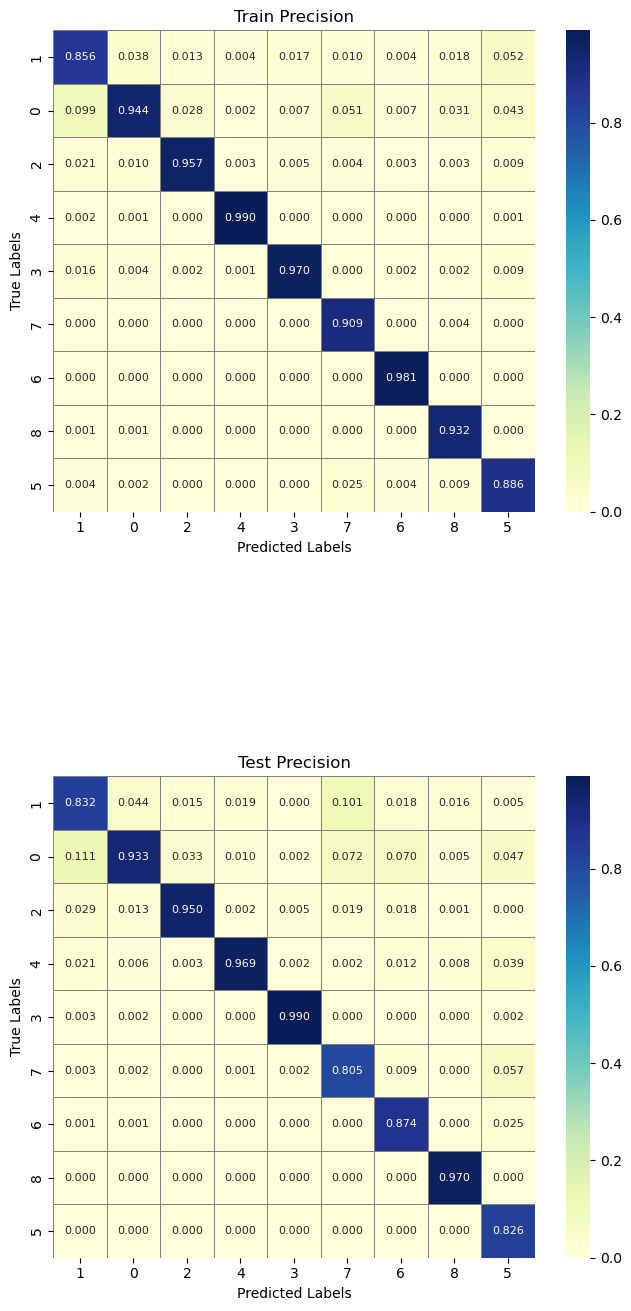

In [49]:
make_confusion_matrices(y_train, y_pred_train, y_test, y_pred)

# Naive Bayes Classifier

### Sci-kit learn multnomial naive bayes

In [28]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [101]:
model = MultinomialNB(fit_prior=True)

In [102]:
start = time.time()  
model.fit(X_train, y_train)
end = time.time()  

print(f"Training Time: {end - start:.4f} seconds")

/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Training Time: 131.3480 seconds


In [103]:
start = time.time()  

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)
end = time.time()  

print(f"Prediction Time on {X_test.shape[0] + X_train.shape[0]} rows: {end - start:.4f} seconds")
print(f'{((X_test.shape[0] + X_train.shape[0]) / (end - start)):4f} records per second')

/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Prediction Time on 1306452 rows: 7.8780 seconds
165834.973863 records per second


In [104]:
test_acc = accuracy_score(y_test, test_pred)
train_acc = accuracy_score(y_train, train_pred)

print(f'Train Accuracy = {train_acc:.4f}, Test Accuracy = {test_acc:.4f}')

Train Accuracy = 0.8779, Test Accuracy = 0.8617


Tests:

- fit_prior True / False:
   - Train Accuracy = 0.8872, Test Accuracy = 0.8761
   - Train Accuracy = 0.7831, Test Accuracy = 0.7467


### NLTK

In [60]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


In [69]:
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('punkt_tab')

In [64]:
relevant_of.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category,clean_memo,is_weekend,is_even_amount
0,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,18.4200,2022-09-26,FOOD_AND_BEVERAGES,t casa del rioexp fairlawn,0,0
1,0,acc_0,Buffalo Wild Wings,26.4700,2022-09-12,FOOD_AND_BEVERAGES,buffalo wild wings,0,0
2,0,acc_0,Oculus CA 04/16,11.7300,2022-04-18,GENERAL_MERCHANDISE,oculus,0,0
3,0,acc_0,LOS GIRASOLES STOW OH 03/08,30.0400,2022-03-09,FOOD_AND_BEVERAGES,los girasoles stow,0,0
4,0,acc_0,BUZZIS LAUNDRY 1 OH 03/28,4.1600,2022-03-29,GENERAL_MERCHANDISE,buzzis laundry 1,0,0


In [65]:
sw = set(stopwords.words('english'))
lem = WordNetLemmatizer()

In [70]:
tks = word_tokenize(relevant_of.clean_memo.values[0])
tks

['t', 'casa', 'del', 'rioexp', 'fairlawn']

In [72]:
tks = [word for word in tks if word.isalpha() and word not in sw]
tks

['casa', 'del', 'rioexp', 'fairlawn']

In [73]:
lem_txt = [lem.lemmatize(word) for word in tks]
lem_txt

['casa', 'del', 'rioexp', 'fairlawn']

In [76]:
relevant_of_copy = relevant_of.sample(frac=0.2)

In [79]:
def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text.lower())  # Lowercase and tokenize
    # Remove stopwords and non-alphabetic tokens
    tokens = [word for word in tokens if word.isalpha() and word not in sw]
    # Lemmatize tokens
    lemmatized_text = [lem.lemmatize(word) for word in tokens]
    # Join back into a single string
    return ' '.join(lemmatized_text)


In [82]:
relevant_of_copy['clean_memo_nltk'] = relevant_of_copy.clean_memo.apply(preprocess_text)

In [83]:
relevant_of_copy.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category,clean_memo,is_weekend,is_even_amount,clean_memo_nltk
1029351,4950,acc_8533,STARBUCKS STORE XXXXX GREENVILLE SC :00,4.2700,2021-04-12,FOOD_AND_BEVERAGES,starbucks store greenville 00,0,0,starbucks store greenville
252102,1196,acc_3377,Schnucks Markets,5.4700,2022-11-23,GROCERIES,schnucks markets,0,0,schnucks market
74574,378,acc_1121,Point Of Sale Withdrawal OAKRIDGE HARDWARE,67.2000,2021-10-24,GENERAL_MERCHANDISE,point of sale withdrawal oakridge hardware,1,0,point sale withdrawal oakridge hardware
44563,200,acc_589,Vacci Pizza Cucina Flvacci,15.4000,2022-07-08,FOOD_AND_BEVERAGES,vacci pizza cucina flvacci,0,0,vacci pizza cucina flvacci
178395,865,acc_2495,PepsiCo,1.7500,2023-05-18,FOOD_AND_BEVERAGES,pepsico,0,0,pepsico


In [84]:
relevant_of['clean_memo_nltk'] = relevant_of.clean_memo.apply(preprocess_text)

In [91]:
def ftr_generation(data, num_bins=10, max_features=1000, max_df=0.85):
    to_remove = ['prism_account_id', 'memo', 'amount', 'posted_date', 'clean_memo',]

    # Binary data
    data['is_weekend'] = (data.posted_date.dt.weekday >= 5).astype(int)
    data['is_even_amount'] = data.amount.apply(lambda x: 1 if x % 1 == 0 and x % 5 == 0 else 0)

    # tifidf data
    vectorizer = TfidfVectorizer(max_features=max_features, max_df=max_df)
    tfidf = vectorizer.fit_transform(data.clean_memo_nltk)
    tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf)
    tfidf_df.columns = 'tfidf_' + vectorizer.get_feature_names_out()

    # date data
    date_data = pd.DataFrame()
    date_data['month'] = 'month_' + data.posted_date.dt.month.astype(str)
    date_data['weekday'] = 'weekday_' + data.posted_date.dt.weekday.astype(str)

    date_enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    date_oh = date_enc.fit_transform(date_data)

    cols = np.concatenate([typ[1:] for typ in date_enc.categories_])
    date_ftrs = pd.DataFrame.sparse.from_spmatrix(date_oh, columns=cols)

    # amount features
    amount_data = pd.DataFrame()
    amount_data['decile_amounts'] = pd.qcut(data.amount, q=10, labels=[f'bin_{num}' for num in range(1, num_bins + 1)])
    
    amount_enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    amount_oh = amount_enc.fit_transform(amount_data)

    cols = np.concatenate([typ[1:] for typ in amount_enc.categories_])
    amount_ftrs = pd.DataFrame.sparse.from_spmatrix(amount_oh, columns=cols)
    

    return pd.concat([data, amount_ftrs, date_ftrs, tfidf_df], axis=1).drop(columns=to_remove)

In [92]:
model_ftrs = ftr_generation(relevant_of)

In [93]:
model_ftrs.columns

Index(['prism_consumer_id', 'category', 'is_weekend', 'is_even_amount',
       'clean_memo_nltk', 'bin_10', 'bin_2', 'bin_3', 'bin_4', 'bin_5',
       ...
       'tfidf_world', 'tfidf_worth', 'tfidf_xfer', 'tfidf_xsolla',
       'tfidf_york', 'tfidf_youtube', 'tfidf_zaxby', 'tfidf_zelle',
       'tfidf_zip', 'tfidf_zynga'],
      dtype='object', length=1031)

In [94]:
ids = model_ftrs.prism_consumer_id.unique()

test_ratio = 0.25
test_size = int(len(ids) * 0.25)

test_ids = np.random.choice(ids, size=test_size, replace=False)

In [95]:
train = model_ftrs[~model_ftrs.prism_consumer_id.isin(test_ids)]
test = model_ftrs[model_ftrs.prism_consumer_id.isin(test_ids)]

In [97]:
train.head()

,prism_consumer_id,category,is_weekend,is_even_amount,clean_memo_nltk,bin_10,bin_2,bin_3,bin_4,bin_5,...,tfidf_world,tfidf_worth,tfidf_xfer,tfidf_xsolla,tfidf_york,tfidf_youtube,tfidf_zaxby,tfidf_zelle,tfidf_zip,tfidf_zynga
0,0,FOOD_AND_BEVERAGES,0,0,casa del rioexp fairlawn,0,0,0,0,1.0000,...,0,0,0,0,0,0,0,0,0,0
1,0,FOOD_AND_BEVERAGES,0,0,buffalo wild wing,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,GENERAL_MERCHANDISE,0,0,oculus,0,0,0,1.0000,0,...,0,0,0,0,0,0,0,0,0,0
3,0,FOOD_AND_BEVERAGES,0,0,los girasoles stow,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,GENERAL_MERCHANDISE,0,0,buzzis laundry,0,1.0000,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [99]:
X_train = train.drop(columns=['prism_consumer_id', 'category', 'clean_memo_nltk'])
y_train = train.category

X_test = test.drop(columns=['prism_consumer_id', 'category','clean_memo_nltk'])
y_test = test.category

del train
del test